In [1]:
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import pandas as pd
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from tqdm import tqdm
import os
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Training block

In [62]:

def training(model, criterion, optimizer, num_epochs, trainloader, testloader = None):
    loss_train_hist = []
    loss_valid_hist = []
    for e in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for batch in trainloader:
            optimizer.zero_grad()
            input_embeds, labels = batch
            input_embeds = input_embeds.float().to(device)
            labels = labels.unsqueeze(1).to(device)
            labels = labels.float()
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        loss_train_hist.append(train_loss/len(trainloader))
        if testloader is not None:
            valid_loss = 0
            model.eval()
            with torch.no_grad():
                for batch in testloader:
                    input_embeds, labels = batch
                    input_embeds = input_embeds.float().to(device)
                    labels = labels.unsqueeze(1).to(device)
                    labels = labels.float()
                    prediction = model(input_embeds)
                    loss = criterion(prediction, labels)
                    valid_loss += loss.item()
                loss_valid_hist.append(valid_loss/len(testloader))
    return loss_train_hist, loss_valid_hist

#### Models block

In [66]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3,
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, 
                      padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, 
                      stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), nn.ReLU()
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction


class RNN(nn.Module):
    def __init__(self, input_size, seq_lentgth, hidden_size, num_classes=1):
        super(RNN, self).__init__()
        #self.dropout = nn.Dropout(0.25)
        self.hidden_size = hidden_size
        self.rnn1 = nn.RNN(input_size, hidden_size, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.rnn3 = nn.RNN(hidden_size, hidden_size, batch_first=True)
        self.Linear1 = nn.Linear(seq_lentgth*hidden_size, 100)
        self.Linear2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x, h_1 = self.rnn1(x)
        x, h_2 = self.rnn2(x, h_1)
        x, _ = self.rnn3(x, h_2)
        x = x.reshape(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return x

class LSTM(nn.Module):
    def __init__(self, input_size, seq_lentgth, hidden_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first = True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, batch_first = True)
        self.Linear1 = nn.Linear(seq_lentgth*hidden_size, 1)
    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        x, (h_1, c_1) = self.lstm1(x, (h_0, c_0))
        x, (h_2, c_2) = self.lstm2(x, (h_1, c_1))
        x, _ = self.lstm3(x, (h_2, c_2))
        x = x.reshape(x.size(0), -1)
        x = self.Linear1(x)
        return x

class Bi_LSTM(nn.Module):
    def __init__(self, input_size, len_seq, hidden_size, n_layers):
        super().__init__()
        self.layers = n_layers
        self.len_seq = len_seq
        self.hidden = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = n_layers, batch_first = True, bidirectional = True)
        self.Linear1 = nn.Linear(len_seq*2*hidden_size, 300)
        self.Linear2 = nn.Linear(300, 1)
    def forward(self, seq):
        output, (_, _) = self.rnn(seq)
        output = output.reshape(-1, self.len_seq*2*self.hidden)
        output = self.Linear1(output)
        output = self.Linear2(output)
        return output

Evaluate step 

In [40]:
def plot_loss(train_loss, valid_loss):
    df = pd.DataFrame(list(zip(train_loss, valid_loss)),
    columns =['train_loss', 'valid_loss'])
    sns.lineplot(data=df)
    plt.show()

def measure_metrics(y_true, y_pred, pred_logits):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1_scor = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, pred_logits)
    return list((accuracy, recall, precision, f1_scor, auc))


def evaluate_model(loader, model):
    m = nn.Sigmoid()
    model.eval()
    ground_truth = []
    all_prob = []
    all_predict = []
    with torch.no_grad():
        for batch in loader:
            input_embeds, labels = batch
            input_embeds = input_embeds.float().to(device)
            labels = labels.unsqueeze(1).to(device)
            labels = labels.float()
            prediction = model(input_embeds)
            prediction = prediction.squeeze(1)
            pred = torch.where(prediction > 0.5, 1, 0)
            all_predict.append(pred.cpu().numpy())
            prob = m(prediction)
            all_prob.append(prob.cpu().numpy())
            ground_truth.append(labels.cpu().numpy())
    all_prob = np.concatenate(all_prob)
    ground_truth = np.concatenate(ground_truth)
    all_predict = np.concatenate(all_predict)
    metrics = measure_metrics(ground_truth, all_predict, all_prob)
    columns = ['accuracy', 'recall', 'precision', 'f1_scor', 'auc']
    metrics = pd.DataFrame(dict(zip(columns, metrics)), index = [0])
    return metrics

#### Process data

In [5]:
def get_desc(df):
    phys_embed = list(df.repr)
    ref_pattern = re.compile(r'\[ [\S\n\t\v ]*?\]')
    all_features = []
    for item in phys_embed:
        ref_content = ref_pattern.findall(item)
        descr_seq = []
        for feature in ref_content:
            arr = np.array([float(ch) for ch in re.sub(r'\[|\]|\n', "", feature).split()])
            descr_seq.append(arr.reshape(1, -1))
        descr_seq = np.concatenate(descr_seq, axis = 0)
        all_features.append(descr_seq)
    for item in all_features:
        assert item.shape == (24, 40)
    return all_features


In [33]:
SEED = 42
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    #torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(SEED)

### READ data

In [7]:
train = pd.read_csv('/kaggle/input/ml-mutational-learning/train.csv')

In [8]:
test = pd.read_csv('/kaggle/input/ml-mutational-learning/test.csv')

In [20]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [21]:
def make_map():
    mapp_ = {}
    for i, ab in enumerate(train['Antibody'].unique()):
        mapp_[ab] = i
    return mapp_

In [22]:
mapp_ = make_map()

In [23]:
def func_(x):
    pos = mapp_[x['Antibody']]
    features = x['repr']
    ab_feature = np.zeros((24, 1))
    ab_feature[pos] = 1
    features = np.concatenate((ab_feature, features), axis=1)
    return features

In [24]:
train['repr'] = train.apply(func_, axis=1)

In [25]:
test['repr'] = test.apply(func_, axis=1)

In [26]:
def get_data(target_ab, train, test, samples = 200):
    target_df = train.loc[train['Antibody'] == target_ab]
    rest_df = train.loc[train['Antibody'] != target_ab]
    target_test = test.loc[test['Antibody'] == target_ab]
    
    sample_target = target_df.sample(n=samples, random_state=SEED)
    
    train_target = sample_target.iloc[:100, :]
    valid_target = sample_target.iloc[100:, :]
    
    return train_target, valid_target, target_test, rest_df

In [28]:
target_ab = 'REGN33'

In [29]:
train_target, valid_target, target_test, rest_df = get_data(target_ab, train, test)

In [30]:
from torch.utils.data import Dataset, DataLoader

In [31]:
class Data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        feature = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        return feature, label

In [32]:
def prepare_dataloader(df, batch_size= 5, shuffle=True, collate_fn = None):
    dataset = Data(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, collate_fn=collate_fn)
    return dataloader

In [43]:
trainloader_rest = prepare_dataloader(rest_df, shuffle=True, batch_size=10)
validloader = prepare_dataloader(valid_target, shuffle=False, batch_size=10)
trainloader_target = prepare_dataloader(train_target, shuffle=True, batch_size=5)
testloader = prepare_dataloader(target_test, shuffle=False, batch_size=50)

In [72]:
model = CNNModel(41, 100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:23<00:00,  1.27it/s]


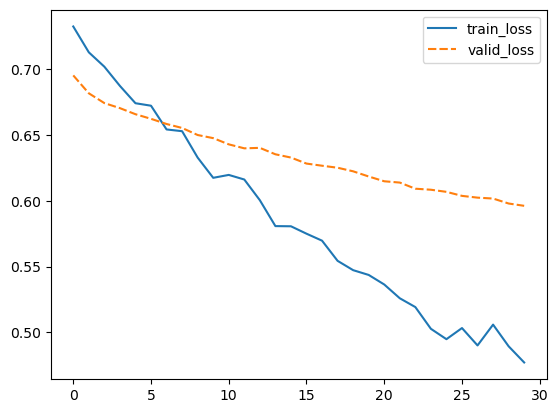

In [73]:
plot_loss(loss_train_hist, loss_valid_hist)

In [74]:
evaluate_model(testloader, model)

,accuracy,recall,precision,f1_scor,auc
0,0.635397,0.314046,0.876936,0.462472,0.810893


In [76]:
model = LSTM(input_size = 41, seq_lentgth = 24, hidden_size = 150, num_classes = 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
num_epochs = 30
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader_target, validloader)

100%|██████████| 30/30 [00:25<00:00,  1.17it/s]


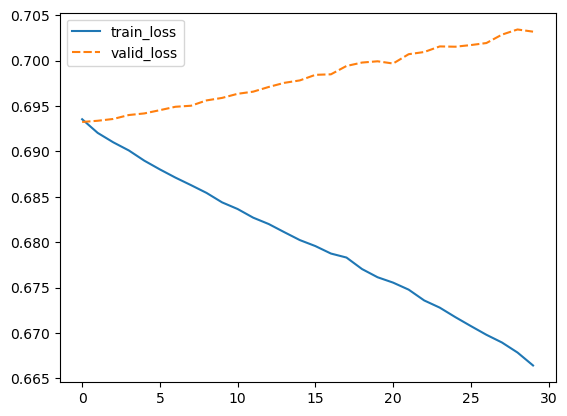

In [77]:
plot_loss(loss_train_hist, loss_valid_hist)

In [78]:
evaluate_model(testloader, model)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,recall,precision,f1_scor,auc
0,0.500562,0.0,0.0,0.0,0.670835


In [5]:
def split_df(df):
    list_df = []
    for i in df['ab'].unique():
        list_df.append(df[df['ab'] == i])
    return list_df
        

In [6]:
class CNNModel(nn.Module):
    def __init__(self, embed_size, hidden_size, num_classes=1):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(embed_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(1),
            nn.Flatten(), nn.ReLU()
        )
        self.cl = nn.Sequential(
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        prediction = self.cl(x)
        return prediction

__One hot encoding__

In [7]:
def process_df(df):
    df = df.loc[:, ['junction_aa', 'Label', 'Antibody']]
    df.columns = ['seq', 'label', 'ab']
    return df
    

In [13]:
train = process_df(pd.read_csv("/kaggle/input/ml-mutational-learning/REGN33_train_data.csv"))
test = process_df(pd.read_csv("/kaggle/input/ml-mutational-learning/REGN33_test_data.csv"))

In [14]:
class My_Data(Dataset):
    def __init__(self, df):
        self.df = df
   

    def encode_seq(self, sequence):
        alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
        char_to_int = dict((c, i) for i, c in enumerate(alphabet))
        integer_encoded = [char_to_int[char] for char in sequence]
        onehot_encoded = list()
        for value in integer_encoded:
            letter = [0 for _ in range(len(alphabet))]
            letter[value] = 1
            onehot_encoded.append(letter)
        return np.array(onehot_encoded)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        seq = self.encode_seq(self.df.seq.iloc[idx])
        label = self.df.label.iloc[idx]
        return seq, label

In [15]:
def make_dataloader(type_df, train_df, test_df, batch_size, frac = 0.3):
    valid = train_df.sample(frac = frac, random_state = SEED)
    train_df.drop(valid.index, inplace = True)
    
    #make datasets
    train_dataset = type_df(train_df)
    valid_dataset = type_df(valid)
    test_dataset = type_df(test_df)

    #make dataloaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    validloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, validloader, testloader

In [16]:
trainloader, validloader, testloader = make_dataloader(My_Data, train, test, batch_size = 180)

In [8]:
def training(model, criterion, optimizer, num_epochs, trainloader, testloader = None):
    loss_train_hist = []
    loss_valid_hist = []
    for e in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for batch in trainloader:
            optimizer.zero_grad()
            input_embeds, labels = batch
            input_embeds = input_embeds.float().to(device)
            labels = labels.unsqueeze(1).to(device)
            labels = labels.float()
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        loss_train_hist.append(train_loss/len(trainloader))
        if testloader is not None:
            valid_loss = 0
            model.eval()
            with torch.no_grad():
                for batch in testloader:
                    input_embeds, labels = batch
                    input_embeds = input_embeds.float().to(device)
                    labels = labels.unsqueeze(1).to(device)
                    labels = labels.float()
                    prediction = model(input_embeds)
                    loss = criterion(prediction, labels)
                    valid_loss += loss.item()
                loss_valid_hist.append(valid_loss/len(testloader))
    return loss_train_hist, loss_valid_hist

In [ ]:
model = CNNModel(embed_size = 20, hidden_size = 80).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 12


In [51]:
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 25/25 [06:47<00:00, 16.31s/it]


In [9]:
def plot_loss(train_loss, valid_loss = None):
    if valid_loss is not None:
        df = pd.DataFrame(list(zip(train_loss, valid_loss)),
               columns =['train_loss', 'valid_loss'])
        sns.lineplot(data=df)
        plt.show()
    else:
        sns.lineplot(data=train_loss)
        plt.show()
        

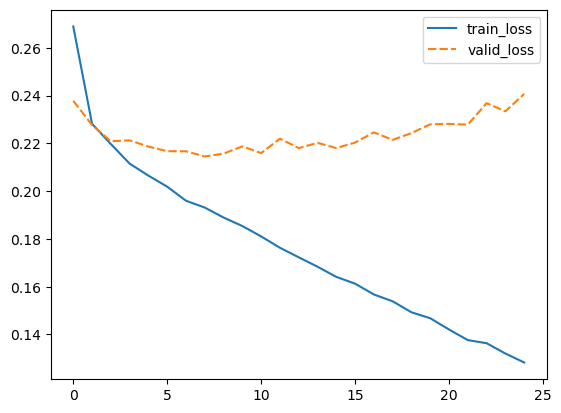

In [58]:
plot_loss(loss_train_hist, loss_valid_hist)

In [16]:
def measure_metrics(y_true, y_pred, pred_logits):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1_scor = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, pred_logits)
    return list((accuracy, recall, precision, f1_scor, auc))

In [17]:
def evaluate_model(loader):
    m = nn.Sigmoid()
    model.eval()
    ground_truth = []
    all_prob = []
    all_predict = []
    with torch.no_grad():
        for batch in loader:
            input_embeds, labels = batch
            input_embeds = input_embeds.float().to(device)
            labels = labels.unsqueeze(1).to(device)
            labels = labels.float()
            prediction = model(input_embeds)
            prediction = prediction.squeeze(1)
            pred = torch.where(prediction > 0.5, 1, 0)
            all_predict.append(pred.cpu().numpy())
            prob = m(prediction)
            all_prob.append(prob.cpu().numpy())
            ground_truth.append(labels.cpu().numpy())
    all_prob = np.concatenate(all_prob)
    ground_truth = np.concatenate(ground_truth)
    all_predict = np.concatenate(all_predict)
    metrics = measure_metrics(ground_truth, all_predict, all_prob)
    columns = ['accuracy', 'recall', 'precision', 'f1_scor', 'auc']
    metrics = pd.DataFrame(dict(zip(columns, metrics)), index = [0])
    return metrics

In [71]:
evaluate_model(testloader)

,accuracy,recall,precision,f1_scor,auc
0,0.91623,0.919215,0.9136,0.916399,0.970642


__Physical features__

In [59]:
#aa_features = pd.read_csv('/kaggle/input/ml-mutational-learning/aa_features.csv')

In [10]:
train_ph = train.merge(aa_features, how = 'inner')

In [11]:
test_ph = test.merge(aa_features, how = 'inner')

In [12]:
train_ph.head()

,seq,label,ab,phys_embed
0,GNTGFNCYCPIKNYGFQRTGGLGW,0,REGN33,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
1,KNTGFNCYLPLVRYGFQTTAGGDW,0,REGN33,[[ 0.00000000e+00 0.00000000e+00 0.00000000e...
2,KNTGFNCYRPLNTYGFWRTSGINY,1,REGN33,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...
3,KNKGFNCYDPITRYGFWPTNGSNW,0,REGN33,[[ 0.00000000e+00 0.00000000e+00 0.00000000e...
4,KNRGFNCYGPLVAYGFQRTCGMGW,0,REGN33,[[ 0.0000000e+00 0.0000000e+00 0.0000000e+00...


In [16]:
import re

In [18]:
def get_desc(df):
    phys_embed = list(df.repr)
    ref_pattern = re.compile(r'\[ [\S\n\t\v ]*?\]')
    all_features = []
    for item in phys_embed:
        ref_content = ref_pattern.findall(item)
        descr_seq = []
        for feature in ref_content:
            arr = np.array([float(ch) for ch in re.sub(r'\[|\]|\n', "", feature).split()])
            descr_seq.append(arr.reshape(1, -1))
        descr_seq = np.concatenate(descr_seq, axis = 0)
        all_features.append(descr_seq)
    for item in all_features:
        assert item.shape == (24, 40)
    return all_features

In [25]:
train_ph['phys_embed'] = get_desc(train_ph)

In [26]:
test_ph['phys_embed'] = get_desc(test_ph)

In [27]:
train_ph.head()

,seq,label,ab,phys_embed
0,GNTGFNCYCPIKNYGFQRTGGLGW,0,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,..."
1,KNTGFNCYLPLVRYGFQTTAGGDW,0,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,KNTGFNCYRPLNTYGFWRTSGINY,1,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,KNKGFNCYDPITRYGFWPTNGSNW,0,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,KNRGFNCYGPLVAYGFQRTCGMGW,0,REGN33,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [24]:
class Physical_df(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        seq = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        return seq, label

In [32]:
trainloader, validloader, testloader = make_dataloader(Physical_df, train_ph, test_ph, batch_size = 180)

In [33]:
model = CNNModel(embed_size = 40, hidden_size = 80).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 12

In [36]:
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)

100%|██████████| 12/12 [01:42<00:00,  8.53s/it]


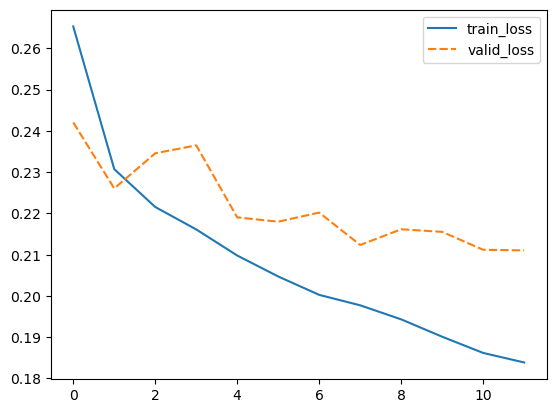

In [41]:
plot_loss(loss_train_hist, loss_valid_hist)

In [55]:
evaluate_model(testloader)

NameError: name 'evaluate_model' is not defined

### __Baseline with 0.3 procent of data__

In [12]:
train = pd.read_csv("/kaggle/input/ml-mutational-learning/train.csv")

In [13]:
test = pd.read_csv("/kaggle/input/ml-mutational-learning/test.csv")

In [19]:
train['repr'] = get_desc(train)
test['repr'] = get_desc(test)

In [51]:
class Data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        feature = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        return feature, label

### seeds for different sample of train data

In [61]:
seeds = np.arange(1, 31, 1)

In [71]:
def make_dataloader(type_df, train_df, test_df, batch_size, seed, frac = 0.3):
    
    sample_train = train_df.sample(frac = 0.3, random_state = seed)
    
    train_dataset = type_df(sample_train)
    test_dataset = type_df(test_df)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [72]:
trainloaders = {}
testloaders = {}
for i, seed in enumerate(seeds):
    trainloader, testloader = make_dataloader(Data, subset_train, subset_test, batch_size = 180, seed = seed)
    trainloaders[i] = trainloader
    testloaders[i] = testloader

In [73]:
metrics = []
for i in trainloaders:
    model = CNNModel(embed_size = 40, hidden_size = 80).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 12
    _, _ = training(model, criterion, optimizer, num_epochs, trainloaders[i])
    metric = evaluate_model(testloader)
    metrics.append(metric)

100%|██████████| 12/12 [00:30<00:00,  2.52s/it]


__Save metrics__

In [85]:

with open('metrics_report', 'wb') as config_file:
    pickle.dump(metrics, config_file)

__Visualize metrics__

In [90]:
auc_metrics = []
for i in range(len(metrics)):
    auc_metrics.append(metrics[i].auc.values[0])
    

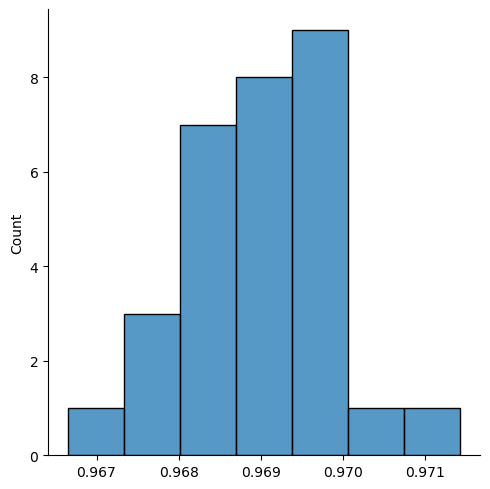

In [92]:
sns.displot(auc_metrics)

__Protein Embeddings__

In [12]:
!pip install fair-esm

In [13]:
import esm

In [14]:
esm_model, esm1v_alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm_model = esm_model.to(device)
converter = esm1v_alphabet.get_batch_converter()

In [16]:
device

'cuda'

In [15]:
def get_data(df, constrain):
    seqs = list(df.seq)
    idx = []
    for seq in tqdm(seqs):
        id_ = converter([('' , seq)])
        idx.append(id_[2])
    repr_ = []
    st = 0
    for i, k in enumerate(range(1500, len(idx), 1500)):
        if i == len(idx)//1500-1:
            k += len(idx) % 1500
        ind = torch.concatenate(idx[st:k]).to(device)
        with torch.no_grad():
            out = esm_model.forward(ind, repr_layers=[33])['representations'][33].to('cpu')
            out = [torch.squeeze(item) for item in list(torch.split(out, 1))]
            repr_.extend(out)
        st += 1500
        torch.cuda.empty_cache()
        print(i)
        if i == constrain:
            break
    labels = list(df.iloc[:len(repr_), :]['label'])
    df_upd = pd.DataFrame(list(zip(repr_, labels)), columns =['emb', 'labels'])
    return df_upd
    

In [16]:
train_emb = get_data(train, 46)

100%|██████████| 120218/120218 [00:40<00:00, 3003.48it/s]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46


In [17]:
test_emd = get_data(test, 40)

100%|██████████| 13358/13358 [00:04<00:00, 2832.48it/s]


0
1
2
3
4
5
6
7


In [18]:
class Esm_df(Dataset):
    def __init__(self, df):
        self.df = df

    def __getitem__(self, idx):
        emb = self.df.emb.iloc[idx]
        label = self.df.labels.iloc[idx]
        return emb, label

    def __len__(self):
        return len(self.df)

In [19]:
trainloader, validloader, testloader = make_dataloader(Esm_df, train_emb, test_emd, batch_size = 180)

In [20]:

model = CNNModel(embed_size = 1280, hidden_size = 80).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 6

In [ ]:
loss_train_hist, loss_valid_hist = training(model, criterion, optimizer, num_epochs, trainloader, validloader)
plot_loss(loss_train_hist, loss_valid_hist)

  0%|          | 0/6 [00:00<?, ?it/s]

In [27]:
evaluate_model(testloader)

,accuracy,recall,precision,f1_scor,auc
0,0.902306,0.893435,0.909382,0.901338,0.964195


In [24]:
evaluate_model(testloader)  # 40*1500

,accuracy,recall,precision,f1_scor,auc
0,0.909343,0.930156,0.892821,0.911106,0.966482


# 3.__antibody_encoding__

In [109]:
train.Antibody.value_counts()

REGN33    120217
REGN87     30089
LY16       26880
LY555      15087
Name: Antibody, dtype: int64

In [110]:
test.head()

,junction_aa,v_call,consensus_count,j_call,clonal_frequency,Label,Distance,Antibody,repr
0,KNTGFNCYFPLLAYGFHPTSGVDY,IGHV_RBD,1,IGHJ_RBD,0.000063,0,6,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,KNPGFNCYHPIVGYGFQPTIGHDF,IGHV_RBD,1,IGHJ_RBD,0.000047,1,9,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,TTAGFNCYMPITRYGFWPTDGRSW,IGHV_RBD,1,IGHJ_RBD,0.000028,0,12,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,RNRGFNCYDPIHKYGFHRTNGLNY,IGHV_RBD,1,IGHJ_RBD,0.000047,1,10,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,KNKKFNCYVPLVTYGFHPTNGVNY,IGHV_RBD,1,IGHJ_RBD,0.000028,0,7,LY16,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [21]:
def make_map():
    mapp_ = {}
    for i, ab in enumerate(train['Antibody'].unique()):
        mapp_[ab] = i
    return mapp_
    

In [22]:
mapp_ = make_map()


In [23]:
def func_(x):
    pos = mapp_[x['Antibody']]
    features = x['repr']
    ab_feature = np.zeros((24, 1))
    ab_feature[pos] = 1
    features = np.concatenate((ab_feature, features), axis=1)
    return features

In [24]:
train['repr'] = train.apply(func_, axis=1)

In [26]:
test['repr'] = test.apply(func_, axis=1)

In [27]:
target_ab = 'REGN33'

In [28]:
SEED = 42

In [29]:
def get_data(target_ab, train, test):
    target_df = train.loc[train['Antibody'] == target_ab]
    rest_df = train.loc[train['Antibody'] != target_ab]
    target_test = test.loc[test['Antibody'] == target_ab]
    
    sample_target = target_df.sample(frac=0.3, random_state=SEED)
    
    train_target = sample_target.iloc[:25000, :]
    valid_target = sample_target.iloc[25000:, :]
    
    return train_target, valid_target, target_test, rest_df

In [30]:
train_target, valid_target, target_test, rest_df = get_data(target_ab, train, test)

In [59]:
class Data(Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __
    
    def __getitem__(self, idx):
        feature = self.df.repr.iloc[idx]
        label = self.df.Label.iloc[idx]
        ab = self.df.Antibody.iloc[idx]
        return feature, label, ab

In [60]:
def prepare_dataloader(df, batch_size= 128, shuffle=True):
    dataset = Data(df)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    return dataloader

In [61]:
trainloader = prepare_dataloader(rest_df, shuffle=True)

In [62]:
validloader = prepare_dataloader(valid_target, shuffle=False)

In [63]:
testloader = prepare_dataloader(target_test, shuffle=False)

In [64]:
a, b, c = next(iter(trainloader))

In [66]:
a.shape

torch.Size([128, 24, 41])

In [67]:
b.shape

torch.Size([128])

In [73]:
dict(zip(c, a))['LY16'].shape

torch.Size([24, 41])

In [77]:
dict(zip(c, a))['LY16'].shape

torch.Size([24, 41])

In [50]:
zip()

('REGN87',
 'LY555',
 'LY555',
 'REGN87',
 'REGN87',
 'LY555',
 'LY16',
 'REGN87',
 'REGN87',
 'REGN87',
 'LY555',
 'LY555',
 'LY16',
 'LY16',
 'REGN87',
 'REGN87',
 'LY16',
 'REGN87',
 'REGN87',
 'REGN87',
 'REGN87',
 'LY16',
 'LY16',
 'LY555',
 'LY16',
 'LY16',
 'LY16',
 'LY16',
 'REGN87',
 'REGN87',
 'LY16',
 'LY16',
 'LY555',
 'REGN87',
 'LY16',
 'REGN87',
 'LY16',
 'LY16',
 'REGN87',
 'LY555',
 'LY16',
 'LY555',
 'REGN87',
 'REGN87',
 'REGN87',
 'LY16',
 'REGN87',
 'LY555',
 'REGN87',
 'LY16',
 'LY16',
 'LY16',
 'REGN87',
 'LY555',
 'REGN87',
 'LY16',
 'LY555',
 'LY555',
 'LY16',
 'LY16',
 'LY16',
 'LY555',
 'REGN87',
 'LY16',
 'REGN87',
 'REGN87',
 'REGN87',
 'REGN87',
 'LY16',
 'LY16',
 'REGN87',
 'LY16',
 'LY16',
 'REGN87',
 'LY16',
 'LY16',
 'LY555',
 'LY16',
 'REGN87',
 'LY555',
 'LY555',
 'LY555',
 'LY16',
 'LY555',
 'LY16',
 'LY16',
 'LY555',
 'LY555',
 'REGN87',
 'REGN87',
 'REGN87',
 'REGN87',
 'REGN87',
 'LY16',
 'LY555',
 'LY555',
 'LY16',
 'LY16',
 'LY555',
 'LY555',
 

In [ ]:
def training(model, criterion, optimizer, num_epochs, trainloader, testloader = None):
    loss_train_hist = []
    loss_valid_hist = []
    for e in tqdm(range(num_epochs)):
        model.train()
        train_loss = 0
        for batch in trainloader:
            optimizer.zero_grad()
            input_embeds, labels = batch
            input_embeds = input_embeds.float().to(device)
            labels = labels.unsqueeze(1).to(device)
            labels = labels.float()
            prediction = model(input_embeds)
            loss = criterion(prediction, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        loss_train_hist.append(train_loss/len(trainloader))
        if testloader is not None:
            valid_loss = 0
            model.eval()
            with torch.no_grad():
                for batch in testloader:
                    input_embeds, labels = batch
                    input_embeds = input_embeds.float().to(device)
                    labels = labels.unsqueeze(1).to(device)
                    labels = labels.float()
                    prediction = model(input_embeds)
                    loss = criterion(prediction, labels)
                    valid_loss += loss.item()
                loss_valid_hist.append(valid_loss/len(testloader))
    return loss_train_hist, loss_valid_hist

In [141]:
def merge_dataloader(type_df, train_df, test_df, batch_size):
    
    train_dataset = type_df(train_df)
    test_dataset = type_df(test_df)

    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return trainloader, testloader

In [144]:
trainloaders = {}
testloaders = {}
for i, train_df in enumerate(train_samples):
    trainloader, testloader = merge_dataloader(Data, train_df, target_test, batch_size = 200)
    trainloaders[i] = trainloader
    testloaders[i] = testloader
    

In [146]:
ab_code_metrics = []
for i in trainloaders:
    model = CNNModel(embed_size = 41, hidden_size = 80).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 12
    _, _ = training(model, criterion, optimizer, num_epochs, trainloaders[i])
    metric = evaluate_model(testloaders[i])
    ab_code_metrics.append(metric)

100%|██████████| 12/12 [01:25<00:00,  7.08s/it]


In [147]:
with open('metrics_report_ab_code', 'wb') as config_file:
    pickle.dump(ab_code_metrics, config_file)

In [148]:
auc_metrics_2 = []
for i in range(len(metrics)):
    auc_metrics_2.append(ab_code_metrics[i].auc.values[0])

In [151]:
auc_metrics_2 = np.array(auc_metrics_2)

In [152]:
auc_metrics = np.array(auc_metrics)

In [153]:
auc_metrics.mean()

0.9690343282549863

In [154]:
auc_metrics_2.mean()

0.9673213996304734